In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1234)

In [3]:
def linear_combination(X, w):
    return X @ w

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def activation(X, w):
    return sigmoid(linear_combination(X, w))

In [6]:
def predict(X, w, threshold):
    return np.where(activation(X, w) > threshold, 1, 0)

Testing the above functions...

In [7]:
X = np.array([[1,20,2],[1,2,2]])
w = np.array([-1,0,1])
class_labels = predict(X, w, threshold=0.5)
print(class_labels)

[1 1]


Setting both L1 and L2 regularization rates such that their sum equals 1, allows to perform elastic regularization.  If either/both regularization isn't needed, set the corresponding rates to 0.

In [8]:
def loss(y, sigmoid_vector, weight_vector, l1_reg_rate, l2_reg_rate):
    loss_orig = -1 * np.sum(y * np.log(sigmoid_vector) + (1 - y) * np.log(1 - sigmoid_vector))
    l2_reg = l2_reg_rate * np.dot(weight_vector.T, weight_vector)
    l1_reg = l1_reg_rate * np.sum(np.abs(weight_vector))
    return loss_orig + l1_reg + l2_reg

In [9]:
def calculate_gradient(X, y, w, reg_rate):
    return X.T @ (sigmoid(linear_combination(X, w)) - y) + reg_rate * w

#### Linear Logistic Regression

Creating a class for LogisticRegression

In [10]:
class LogisticRegression():
    def set_weight_vector(self, w):
        self.w = w
    def linear_combination(self, X):
        return X @ self.w
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def activation(self, X):
        return self.sigmoid(self.linear_combination(X))
    def predict(self, X, threshold=0.5):
        return np.where(self.activation(X) > threshold, 1, 0)
    def loss(self, X, y, reg_rate):
        sigmoid_vector = self.activation(X)
        loss_orig = -1 * np.sum(y * np.log(sigmoid_vector) + (1 - y) * np.log(1 - sigmoid_vector))
        reg = reg_rate * np.dot(self.w.T, self.w)
        return loss_orig + reg
    def calculate_gradient(self, X, y, reg_rate):
        return X.T @ (self.activation(X) - y) + reg_rate * self.w
    def update_weights(self, grad, lr):
        return self.w - grad * lr
    def gd(self, X, y, num_epochs, lr, reg_rate):
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []
        for i in range(num_epochs):
            grad = self.calculate_gradient(X, y, reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X, y, reg_rate))
            self.w = self.update_weights(grad, lr)
        return self.w

In [11]:
def create_toy_data():
    x0 = np.random.normal(size=50).reshape(-1, 2) - 1
    x1 = np.random.normal(size=50).reshape(-1, 2) + 1
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

In [12]:
feature_matrix, label_vector = create_toy_data()
print(feature_matrix.shape, label_vector.shape)

(50, 2) (50,)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [13]:
import itertools
def combinations(x, degree):
    return itertools.combinations_with_replacement(x, degree)

In [14]:
import functools
def compute_new_features(items):
    return functools.reduce(lambda x, y: x * y, items)

In [15]:
def polynomial_transform(x, degree):
    if x.ndim == 1:
        x = x[:, None]

    features = [np.ones(len(x))] #a list of np-arrays with all 1.

    for degree in range(1, degree + 1):
        for item in combinations(x.T, degree):
            features.append(compute_new_features(item))
            
    return np.asarray(features).T

In [16]:
feature_matrix_bias = polynomial_transform(feature_matrix, degree=1)
feature_matrix_bias.shape

(50, 3)

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(feature_matrix_bias, label_vector) 
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(37, 3) (13, 3) (37,) (13,)


<AxesSubplot:>

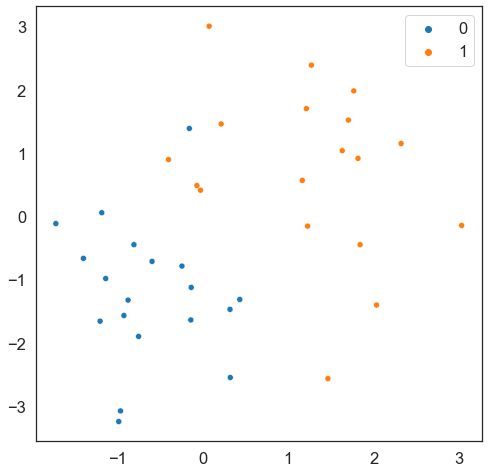

In [18]:
sns.set_style("white")
f = plt.figure(figsize=(8,8))
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=y_train)

In [19]:
log_reg = LogisticRegression()
log_reg.gd(x_train, y_train, num_epochs=1000, lr=1e-2, reg_rate=0)

array([-0.14559758,  4.43289743,  1.94514132])

In [20]:
def plot_learning_curve(err):
    plt.plot(np.arange(len(err)), err, 'r-')

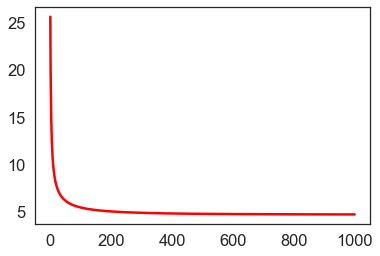

In [21]:
plot_learning_curve(log_reg.err_all)

In [22]:
# same as in previous section
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

def visualize_model(X_train, labels, lsc, degree=1):
    f = plt.figure(figsize=(8,8))

    x1_min = np.min(x_train[:,1])
    x1_max = np.max(x_train[:,1])
    x2_min = np.min(x_train[:,2])
    x2_max = np.max(x_train[:,2])
    
    x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100)) 
    x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test = lsc.predict(x_test_poly, 0.5)
    
    sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100,100), alpha=0.5, levels=np.linspace(0,1,3))
    plt.gca().set_aspect('equal', adjustable='box')

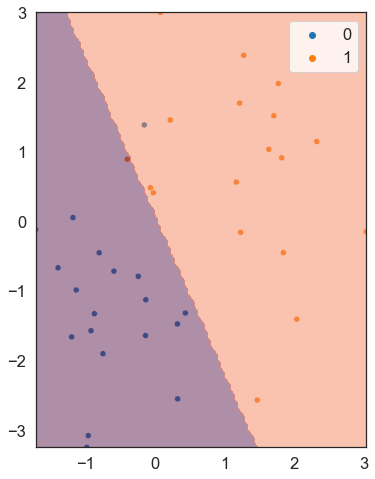

In [23]:
visualize_model(x_train, y_train, log_reg)

In [24]:
y_test_hat = log_reg.predict(x_test)

In [25]:
#using the sklearn to generate the evaluate metrics, rather than using our functions
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



#### Non-linear Logistic Regression

In [26]:
from sklearn.datasets import make_circles
feature_matrix, label_vector = make_circles()

D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [27]:
x_poly = polynomial_transform(feature_matrix, degree=2)

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_poly, label_vector) 
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 6) (25, 6) (75,) (25,)


<AxesSubplot:>

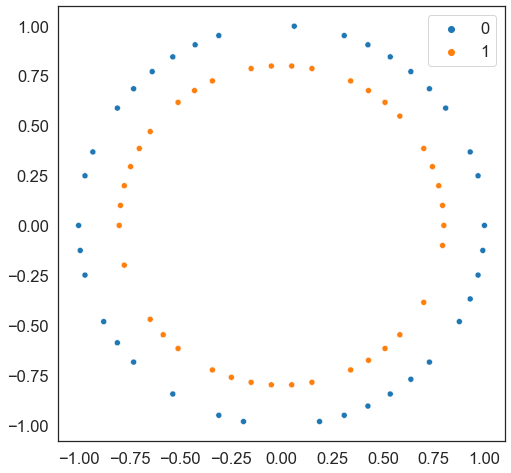

In [29]:
sns.set_style("white")
f = plt.figure(figsize=(8,8))
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=y_train)

In [30]:
log_reg_poly = LogisticRegression()
log_reg_poly.gd(x_train, y_train, num_epochs=10000, lr=1e-2, reg_rate=0)

array([ 2.03212877e+01, -3.62360899e-02,  7.36788518e-03, -2.49434641e+01,
        1.06058158e-01, -2.47207876e+01])

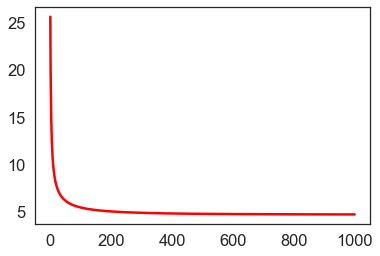

In [31]:
plot_learning_curve(log_reg.err_all)

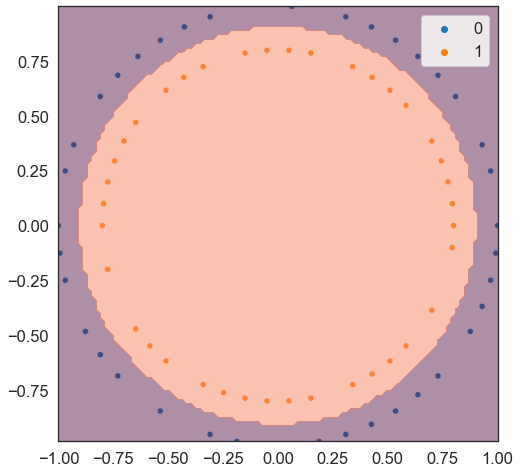

In [32]:
visualize_model(x_train, y_train, log_reg_poly, degree=2)

In [33]:
y_test_hat = log_reg_poly.predict(x_test)

In [34]:
#using the sklearn to generate the evaluate metrics, rather than using our functions
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

